In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import json
import time
import unidecode as ud
import re
import unicodedata

# Preamble and things that occurred before the notebook:

With the idea that we would look through reddit comments and try to do topic analysis, the first question was, how do we gather data.  Tiphanie pointed out a huge repository of reddit comments, but the data was generally too large to process.  With the exception of the earlier years in the dataset, all of the partitions of the data were several gigabytes or larger, which made it very hard, if not impossible, to do data cleaning.

The first step then, was to use Google's BigQuery to query a subset of the data that would be manageable.  Knowing we wanted to look at political topics, we restricted ourselves to the 'political', 'worldnews', and 'wordevents' subreddits.  Additionally throwing out some features that we didn't think would help us, we could get the early datasets down to just a few hundred megabytes in size, and the later ones down to a couple gigabytes.  The datasets were large, but manageable.

So, BigQuery did the first round of data cleaning for us.  The files were then transferred to google storage (direct download wasn't possible for the file sizes) and downloaded.

With data in hand, the cleaning phase began.  Code was tested on the 2007 data set, and then heavily revised for the 2014 dataset when it became apparent that they were not as similar as anticipated.

Determining what to do
Getting the data from BigQuery
Problems with downloading the data
Problems with 2007 vs 2014

# Opening and loading the data!

In [2]:
%%time

data = []
with open('2014big.json') as f:
    for line in f:
        data.append(json.loads(line))

CPU times: user 52.6 s, sys: 7.12 s, total: 59.7 s
Wall time: 59.9 s


In [3]:
%%time

data = []
with open('2014big.json') as f:
    data = [json.loads(line) for line in f]


CPU times: user 53.6 s, sys: 8.12 s, total: 1min 1s
Wall time: 1min 1s


So list comprehension didn't save me any time :-(.  What was 4-5 seconds to load 83MB is now a minute and a half to load 1.25GB.

# What do the data look like?

Like the caption says

In [4]:
# curious about how much data we have:

len(data)

2677202

Ok, hopefully that's enough to work with.  And what do these entries look like?

We're up from 200K to 2M entries.  In all likelihood, I will probably pare that down.

In [5]:
data[1:3]

[{u'author': u'bucknuggets',
  u'body': u"Yeah, please provide the quotes that show that he thought gay marriage would lead to phedophilia and beastiality.\n\nOr are we just talking about someone saying that he didn't want to be defined as a single-value politician and so would leave to others to lead.\n\nBecause the two are *vastly* different.",
  u'controversiality': u'0',
  u'created_utc': u'1407849031',
  u'downs': u'0',
  u'id': u'cjo0hkw',
  u'link_id': u't3_2daoq2',
  u'name': u't1_cjo0hkw',
  u'parent_id': u't1_cjnzhxj',
  u'score': u'13',
  u'ups': u'13'},
 {u'author': u'[deleted]',
  u'body': u'Was Clinton any good though?  Last I remember he watered down the glass steagal and lowered banking regulations, which some say helped bring about the financial crisis.  Then he had sanctions on Iraq which killed hundreds of thousands, mainly children.  It seems like it doesnt really matter whose in office.',
  u'controversiality': u'0',
  u'created_utc': u'1398952953',
  u'downs': u'0

In [6]:
# turn "data" into a dataframe"
df = pd.DataFrame(data)

# display what the data looks like
df.head()

author                                               body controversiality created_utc downs       id    link_id        name   parent_id score ups
0         gbs5009  It may be "legit" in that the progressive grou...                0  1390595859     0  cexzy6w  t3_1vyqx3  t1_cexzy6w  t1_cexyihx     1   1
1     bucknuggets  Yeah, please provide the quotes that show that...                0  1407849031     0  cjo0hkw  t3_2daoq2  t1_cjo0hkw  t1_cjnzhxj    13  13
2       [deleted]  Was Clinton any good though?  Last I remember ...                0  1398952953     0  ch6up9g  t3_24dja2  t1_ch6up9g  t1_ch6lce0     1   1
3  Dreamstakeroot  What if I told you that both Democrats and Rep...                0  1396628643     0  cgk02xx  t3_226zi6  t1_cgk02xx  t1_cgjxnhd    -8  -8
4   areyakiddinme                                    happy cake day!                0  1414456941     0  cllonjm  t3_2kgqt2  t1_cllonjm  t1_cllo3z6     1   1

## What kind of data types are we working with?

First things first, we need to check the data types.  I know this because I didn't check the data types the first time I went through this, and quantitative comparisons were giving screwy results.

In [7]:
# listing data types

df.dtypes

author              object
body                object
controversiality    object
created_utc         object
downs               object
id                  object
link_id             object
name                object
parent_id           object
score               object
ups                 object
dtype: object

Lots of data there that is of the "wrong" type.  We'll fix that now.

In [8]:
# convert the numeric "objects" into floats.
df[['ups', 'downs','score','controversiality']] = df[['ups', 'downs','score','controversiality']].astype(float)

# reassess our data
df.dtypes 

author               object
body                 object
controversiality    float64
created_utc          object
downs               float64
id                   object
link_id              object
name                 object
parent_id            object
score               float64
ups                 float64
dtype: object

# Digging into the data

Much better.  Now, what do our ups and downs look like?

In [9]:
df.downs, df.ups

(0          0
 1          0
 2          0
 3          0
 4          0
 5          0
 6          0
 7          0
 8          0
 9          0
 10         0
 11         0
 12         0
 13         0
 14         0
 15         0
 16         0
 17         0
 18         0
 19         0
 20         0
 21         0
 22         0
 23         0
 24         0
 25         0
 26         0
 27         0
 28         0
 29         0
           ..
 2677172    0
 2677173    0
 2677174    0
 2677175    0
 2677176    0
 2677177    0
 2677178    0
 2677179    0
 2677180    0
 2677181    0
 2677182    0
 2677183    0
 2677184    0
 2677185    0
 2677186    0
 2677187    0
 2677188    0
 2677189    0
 2677190    0
 2677191    0
 2677192    0
 2677193    0
 2677194    0
 2677195    0
 2677196    0
 2677197    0
 2677198    0
 2677199    0
 2677200    0
 2677201    0
 Name: downs, dtype: float64, 0            1
 1           13
 2            1
 3           -8
 4            1
 5            1
 6            2
 7   

It appears that the downs aren't giving us any meaningful data, and the ups aren't giving us strictly positive numbers, as anticipated.  Let's take a deeper look at our quantitative data and see what exactly we're dealing with.

In [11]:
df.describe()

controversiality    downs           score             ups
count    2677202.000000  2677202  2677202.000000  2677202.000000
mean           0.038882        0        4.451874        4.451874
std            0.193314        0       29.627420       29.627420
min            0.000000        0     -279.000000     -279.000000
25%            0.000000        0        1.000000        1.000000
50%            0.000000        0        1.000000        1.000000
75%            0.000000        0        3.000000        3.000000
max            1.000000        0     5135.000000     5135.000000

Score and ups are indistinguishable, and downs are useless.  We'll trim both the ups and downs from our dataset, while keeping the correctly labeled composite of the two, score.

We'll keep controversiality as there appear to be 3% controversial reviews (in previous years, this label hadn't been invented yet, so it too was reading uniformly 0, but with the 2014 dataset, it does actually have some meaning.

In [12]:
# dropping the useless data

df = df.drop(['ups','downs'], 1)

In [13]:
df.head()

author                                               body  controversiality created_utc       id    link_id        name   parent_id  score
0         gbs5009  It may be "legit" in that the progressive grou...                 0  1390595859  cexzy6w  t3_1vyqx3  t1_cexzy6w  t1_cexyihx      1
1     bucknuggets  Yeah, please provide the quotes that show that...                 0  1407849031  cjo0hkw  t3_2daoq2  t1_cjo0hkw  t1_cjnzhxj     13
2       [deleted]  Was Clinton any good though?  Last I remember ...                 0  1398952953  ch6up9g  t3_24dja2  t1_ch6up9g  t1_ch6lce0      1
3  Dreamstakeroot  What if I told you that both Democrats and Rep...                 0  1396628643  cgk02xx  t3_226zi6  t1_cgk02xx  t1_cgjxnhd     -8
4   areyakiddinme                                    happy cake day!                 0  1414456941  cllonjm  t3_2kgqt2  t1_cllonjm  t1_cllo3z6      1

ID and Name appear to be the same accept for a prefix to a consistent prefix to name, so I'll drop name as well. Truth be told, I don't know what id, name, and parent_id are, so I'll drop all three for now to save memory.

I'll reinstate these variables later if need be.

Side Note: In theory, in the description of the data, the link_id was supposed to allow us to revisit the page the data had been scraped from.  With that piece on information, I was hoping to scrape the original headline for the articles that the comments stemmed from.  When this didn't work with the 2007 data, I was hopeful it was a flaw in the data the way that controversiality proved to be nonexistent in 2007, but existing in 2014, but such was not the case.  So, in future work (at least one of us plans to use this project as the beginning of a thesis), there will be scraping of headlines as well as articles to go with comment scraping ... just not in this project, sadly.



In [14]:
df = df.drop(['name','id','parent_id'], 1)

Time for a plot to see what our score distributions look like.

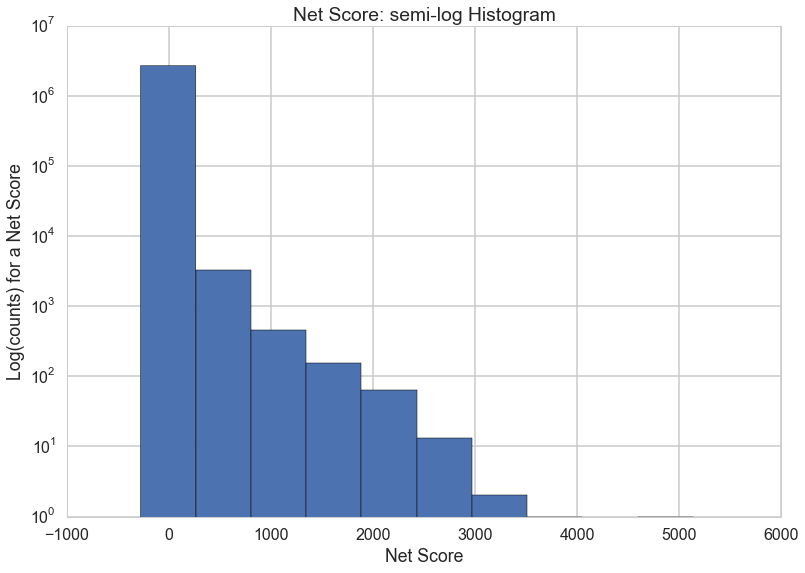

In [15]:
df.score.plot(x = "ups",y = "log(counts)", kind = 'hist',logy = True)
plt.xlabel("Net Score")
plt.ylabel("Log(counts) for a Net Score")

plt.title("Net Score: semi-log Histogram")

Looks like the net scores have very very small tails, with the right tail being much heavier than the left.

The semi-log histogram suggests the data was pretty close to 1, but how close?

In [16]:
%%time

d = 0
for i in [-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11]:
    t = sum(df.score == i)
    d = d + t
    print t
print "within domain counts: ",d
print "within domain probability: ",d/2677202.

23198
27769
52707
102826
259217
941117
386611
201335
94959
86248
66713
49822
38801
31021
25435
20683
within domain counts:  2408462
within domain probability:  0.89961907992
CPU times: user 1min 42s, sys: 75.9 ms, total: 1min 42s
Wall time: 1min 42s


So the data is spread VERY tightly around the mean of 4.45.  Anything above 11 or below -4 is outermost 10%-ish, while the range of scores goes as low as -279 and as high as 5135

## Creating new data columns

Now to start picking apart the comments.  I was hopeful that this would go very quickly after having worked on, and debugged, the smaller 2007 data set.  Unfortunately, that actually proved not to be the case.  In both the smaller and larger data sets, there were weird unicode designations.  In 2007, it was mostly letters with accents over them, and that proved relatively easy to remove once I knew what was going on.  In 2014, there were many many more things to remove and I couldn't rely on manually removing a few special cases.  Specifically, emoji had come onto the scene by 2014, and a myriad different smiley faces needed some more algorithmic deletion.

How many words and sentences in each comment?  (I'll do this again before I'm done because of the problems above, but here was an initial run).

In [20]:
# sampling the split function on the text in 10 different comments
test = df.body[1:10].apply(lambda x: x.split())
print test

# counting the words in 10 different comments
test.apply(lambda x: len(x))

1    [Yeah,, please, provide, the, quotes, that, sh...
2    [Was, Clinton, any, good, though?, Last, I, re...
3    [What, if, I, told, you, that, both, Democrats...
4                                  [happy, cake, day!]
5    [ISIS, is, that, uprising, in, the, Middle, Ea...
6    [We've, had, a, base, in, Cuba, for, almost, a...
7    [Which, they?, And, how, are, they, enemies, o...
8    [I, am, aware, that, things, cost, money,, gre...
9    [amazing, how, you, misunderstand, my, positio...
Name: body, dtype: object


1    51
2    50
3    48
4     3
5     8
6    37
7    10
8    42
9    45
Name: body, dtype: int64

The schema above appeared to work.  In the subsequent cell, we create a new column called "words" which counts the number of words in the body of a comment, and adds this as a new feature to our dataframe.

In [21]:
%%time

# split will take the text from the body of one row from our dataframe and break
# it apart on the space character yielding a bunch of "words."  These aren't 
# necessarily all words, but it's a pretty good first approximation.

# The result of split is a list.  We count the number of elements in that list
# and return that as the ESTIMATED number of words in a review.

# This process is repeated for every row in the dataframe.

df['words'] = df.body.apply(lambda x: len(x.split()))

CPU times: user 15.5 s, sys: 313 ms, total: 15.8 s
Wall time: 15.6 s


In [22]:
# what do things look like?

df.head()

author                                               body  controversiality created_utc    link_id  score  words
0         gbs5009  It may be "legit" in that the progressive grou...                 0  1390595859  t3_1vyqx3      1     91
1     bucknuggets  Yeah, please provide the quotes that show that...                 0  1407849031  t3_2daoq2     13     51
2       [deleted]  Was Clinton any good though?  Last I remember ...                 0  1398952953  t3_24dja2      1     50
3  Dreamstakeroot  What if I told you that both Democrats and Rep...                 0  1396628643  t3_226zi6     -8     48
4   areyakiddinme                                    happy cake day!                 0  1414456941  t3_2kgqt2      1      3

Run time is surprisingly fast on the word count function.  Just curious now to see what our distribution of word counts looks like:

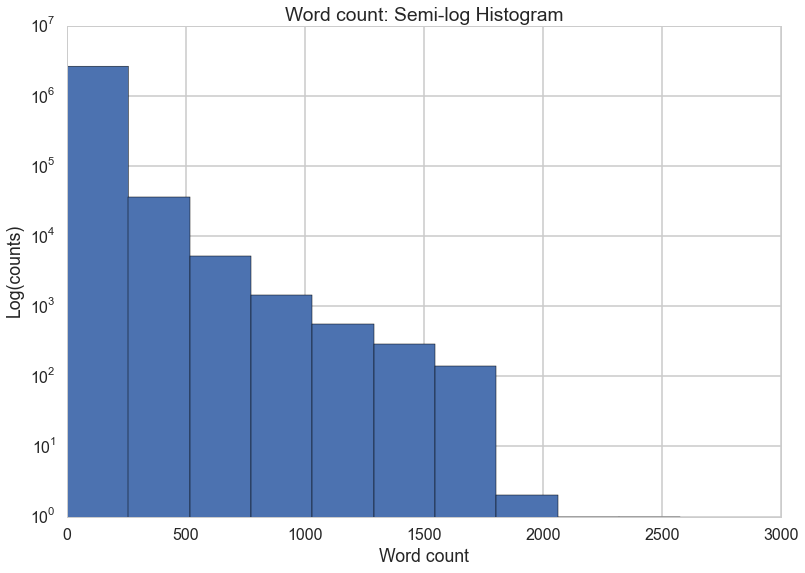

In [23]:
df.words.plot(kind = 'hist',logy = True)

plt.title("Word count: Semi-log Histogram")
plt.xlabel("Word count")
plt.ylabel("Log(counts)")

So the vast majority of comments are short, but still some longer stuff and at least a novel or two to take a look at.

Next we try and count the number of sentences in each comment.  This will be a bit trickier as we have to pay some attention to context.  Is a period at the end of a sentence, abbreviation, acronym, or some combination of the above?  The function terminal_punc_est() is so named because it is an estimate intended to get close to the actual number of sentences.

In [24]:
# checks if a word is an abbreviation or ellipsis.  Can be added to.
def abbrev(word):
    return (word in ['Mr.','mr.','Mrs.','mrs.','Ms.','ms.','...'])
    
# checks if a word has multiple dots, high likelihood of being an acronym
def acronym(word):
    letters = [word.split()]
    dots = 0
    for letter in letters:
        if letter == '.':
            dots = dots + 1
    return dots > 1

# rough estimate of the number of sentences. It's not perfect,
# but it does some error checking for acronyms and abbreviations
def terminal_punc_est(text):
    word_list = text.split()
    terminal_periods = 0
    for entry in word_list:
        
        # exclamation and question marks are more often than not ends of sentences
        if entry[-1] in ['!','?']:
            terminal_periods = terminal_periods + 1
        # periods require further analysis.
        elif entry[-1] == '.':
            # if we're not an abbreviation and we're not an acronym, a period is
            # probably terminal.
            if not abbrev(entry) and not acronym(entry):
                terminal_periods = terminal_periods + 1
            # if a word is an abbreviation or an acronym, and it ends in two periods
            # it is probably terminal.
            elif entry[-2] =='.':
                terminal_periods = terminal_periods + 1
        # a case I was running into frequently was finding a period and a quote.
        # if we find a period and a quote at the end of a word, that's probably
        # the end of a sentence.
        elif entry[-2:] == '."':
            terminal_periods = terminal_periods + 1
    return terminal_periods


# I realize now that I'm not handling ellipses adequately, but it's too late to go
# back and make changes this late in the game.  In future renditions
# of this project, ellipses will need further care.

Like with words counting before, the following cell applies a function to all the rows of the dataframe and makes an estimate of the number of sentences for each row, ultimately adding a new column to the dataframe that estimates the number of sentences per comment. 

In [25]:
%%time
df['sentences'] = df.body.apply(terminal_punc_est)

CPU times: user 1min 52s, sys: 2.74 s, total: 1min 55s
Wall time: 1min 53s


Given how many embedded functions and corner cases have to run for sentence counting as opposed to word counting, I'm surprised this runs as fast as it does.

Having taken a newer dataset, the controversiality tag is actually working.  Now let's take a look at what we have and jump into the time consuming steps:

In [27]:
df

author                                               body  controversiality created_utc    link_id  score  words  sentences
0                     gbs5009  It may be "legit" in that the progressive grou...                 0  1390595859  t3_1vyqx3      1     91          5
1                 bucknuggets  Yeah, please provide the quotes that show that...                 0  1407849031  t3_2daoq2     13     51          3
2                   [deleted]  Was Clinton any good though?  Last I remember ...                 0  1398952953  t3_24dja2      1     50          4
3              Dreamstakeroot  What if I told you that both Democrats and Rep...                 0  1396628643  t3_226zi6     -8     48          3
4               areyakiddinme                                    happy cake day!                 0  1414456941  t3_2kgqt2      1      3          1
5                ikilledtupac          ISIS is that uprising in the Middle East.                 0  1411749550  t3_2hhsq6      1      8          1
6              GetToDaChoppa1  We've had a base in Cuba for almost a century ...                 0  1411400729  t3_2h3e4n      2     37          3
7               sailorbrendan  Which they? And how are they enemies of the st...                 0  1406909859  t3_2cbsek      4     10          2
8                  peedmyself  I am aware that things cost money, great quest...                 0  1405110445  t3_2a1kg8      1     42          2
9            YouReallyThinkSo  amazing how you misunderstand my position, and...                 0  1402691238  t3_27byvg      0     45          0
10                    apeweek  Funny story, Texas was actually lobbying for t...                 0  1414035775  t3_2k0quj     22     33          2
11              thesecretbarn  1. Yes. Those metropolitan districts contain m...                 0  1411690914  t3_2hh2lv      1    170         21
12             Ninjabackwards  /r/conspiracy looks like a great place for you...                 0  1404538716  t3_29p3z1      1     14          3
13                Judg3Smails  Something something shrinking middle class!\n\...                 0  1391452814  t3_1ww0p7      0     29          4
14             Pater-Familias  Ah okay, so single payer was never seriously g...                 0  1405698527  t3_2b120j    -14     83          4
15               UserMCMLXXXV  &gt; No one is out hunting illegals or anythin...                 0  1416539050  t3_2mxl52      2     17          3
16                  darthn3ss  If diesel were cheaper , most Americans would ...                 0  1390045628  t3_1vg7u4      1     32          1
17                      Jrook  You should write a book, or ask your parents f...                 0  1393703245  t3_1z9kxf     -2     14          1
18             shwarma_heaven  Of course paying taxes is patriotic - taxation...                 0  1406210441  t3_2bld7j      5     34          2
19                  [deleted]  Marriage licenses are unconstitutional. Nobody...                 0  1393467371  t3_1z0job     -2     13          2
20                   ristoril  Nothing says "civil discourse" better than the...                 0  1412012756  t3_2hs72b      1     52          2
21               Harbingerx81  I mean in cases like responding to a reported ...                 0  1417196348  t3_2nnww2      2    163          4
22                  [deleted]                                          [deleted]                 0  1393411076  t3_1yyurk      1      1          0
23                   Uriniass  "That's all we do in the Senate is vote on thi...                 0  1409156032  t3_2eqclt    180     72          3
24              Watcher_woman  Can you give me sources on how online voting i...                 0  1416288840  t3_2mj0om      1     34          2
25                davydagger1  the NDAA is what re-authorizes the military, a...                 0  1409418674  t3_2f093v     11    195         13
26               FuckJohnGalt                        Y

Lots of non-ascii characters are going to need to be removed.  And standard end of line or end of row and various other escaped characters need to be handled.

Before I forget, quick interjection.  I want to create a variable indicating if a comment is positive or non-positive:

In [28]:
df['positive'] = 1 * (df.score > 0)

One of the major problems with dealing with this corpus is that it is highly quoted.  This isn't a problem I remember encountering in homework 5, but in political debate, or in comment sections in general, there tends to be a lot of back and forth between readers reading other posters and responding to each other.

Subsequently, you would end up double counting a lot of words and sentences, possibly entire statements, if you just threw out the odd characters and broke down the text into words and sentences.

The upside is that this is an interesting feature we can count (and will do next).  The downside, is that we have more processing to do.

In [29]:
# this function counts the number of reply symbols that show up in the comment text
# it isn't an exact of how many pieces of quoted text are replied to, but it's a reasonable
# approximation. (some comments have a terminal quote_block symbol, and some commenters
# use the reply symbol for other purposes)

def reply_count(text):

    # initialize the count
    count = 0
    
    # split text into words
    list_of_words = text.split()

    # for each word, if it begins with 
    for word in list_of_words:
        # apparently if you ask for more letters than the word has, there is no error and you get the entire word.
        if word[:4] == '&gt;':
            count = count + 1
    
    return count

In [30]:
%%time

df['reply_count'] = df.body.map(reply_count)

CPU times: user 37.4 s, sys: 2.4 s, total: 39.8 s
Wall time: 37.9 s


What does the number of replies look like?

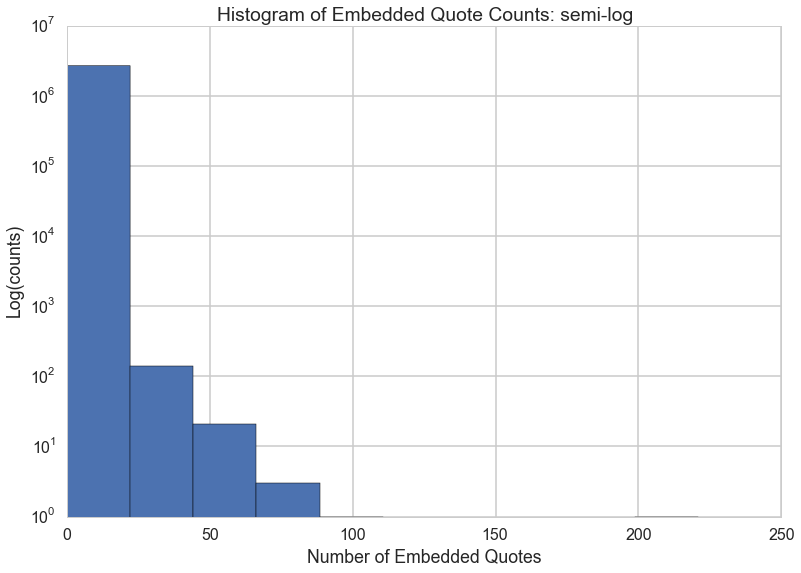

In [31]:
df.reply_count.plot(kind = "hist",logy = True)
plt.title("Histogram of Embedded Quote Counts: semi-log")
plt.ylabel("Log(counts)")
plt.xlabel("Number of Embedded Quotes")

In [32]:
for i in range(0,20):
    print i, sum(df.reply_count == i)

0 2431819
1 174758
2 35094
3 15745
4 8023
5 4463
6 2343
7 1558
8 919
9 635
10 439
11 323
12 210
13 177
14 144
15 89
16 89
17 54
18 50
19 26


We can see that the vast majority of comments have a small number, if any, of embedded quotes within their text.  But, there are still about 200K comments that recycle comments from other posts, so we'll have to edit that out, and then recount words and sentences.

How to filter out the text of the embedded quotes?  We'll start by looking at what comments with embedded quotes look like.

In [33]:
test = df.body[df.reply_count == 3]
test.head()

30     &gt; The unions take care of union workers wit...
43     You can't be serious! Bush "just squeaked by" ...
172    &gt; this is one of the most hypocritical stat...
237    &gt;&gt;  There is the money you earn, the mon...
244    &gt; How can you not trust the World Socialist...
Name: body, dtype: object

In [34]:
test = test.reset_index()

In [35]:
test.body[1]

u'You can\'t be serious! Bush "just squeaked by" and what in the hell did that do? A candidate owes his allegiance to his political party and the private interest groups that back it. Anyone incorruptible- such as your Ron Pauls, are gratuitously campaigned against and slandered as "crazy" for whatever personal beliefs the party thinks will STICK with the public so that a wild card won\'t be elected. You want to know what happened to the last wild card that vehemently disavowed private interest groups once in office?  He was fucking assassinated and then his family was picked off. \n\nhttp://www.youtube.com/watch?v=YafZkjiMpjU\n\n&gt;even today, there is little value in ensuring the value of our nation, if our traditions do not survive with it. And there is very grave danger, that an announced need for increased security will be ceased upon by those anxious to expand upon its meaning, to the very limits of official censorship and concealment. That I do not intend to permit to the exten

In [36]:
test.body[2]

u'&gt; this is one of the most hypocritical statements you could have made. Why is it that I cannot force my beliefs on others but others can force their beliefs on me? Same sex marriage does not ONLY affect the lives of the people. It affects everyone. case in point....\n\nAre you seriously comparing being denied the right to marry the consenting adult of your choosing to having to bake a cake in a bakery?\n\nIt also denies death benefits and sometimes the right to be present when your loved ones and family are dying.\n\nLet me explain something, those gay people frequently have jobs and pay taxes which help to fund the infrastructure and utilities that businesses use.  \n\nThis means that businesses benefit from those people.  So part of the contract we have for using society\'s resources is that we don\'t discriminate.  We don\'t deny services because we\'re bigots.\n\n&gt;I would like to see them. Can you please list off hundreds or more of the cases\n\nwww.google.com\n\n1.  So, I 

### Analysis of text

The pattern in most of the cases is that the quoted text goes from the special character '&gt;' to the first \n\n or \r\n.  Then new text flows from there until the next quoted text character (&gt;).  So, as a rough approximation, I should cut out anything between a quoted text character and the subsequent \n\n or \r\n characters.  I think it might be easier to just run from the special character to the \n character and chop that off.  Looking at the above, there is one case where this algorithm appears to falter, but this looks like it gives the right result 90%+ of the time.

I can revisit this if I come up with a better method, although I think a better method at this point will involve actually reading all the comments, which is certainly better, but not time efficient.

In [37]:
# need to read characters into a new character list until "&gt;" shows up,
# then not read until a \n or \r, then start reading again

def strip_replies(text):
    # initialize the return text
    clean_text = ""
    
    # variable assignment of the odd characters to prevent retyping
    quote_block = "&gt;"
    
    # noting the length of the text so I don't overshoot the array
    # of characters and create an error from an invalid read
    text_length = len(text)
    
    # initializing where in the text string we are
    i = 0
    
    # this loop will run from the beginning to end of a piece of text stripping out text
    # that appears after the 
    while i in range(0,text_length):

        # if we identify embedded quotes, skip that character and start cutting text
        if text[i:i+4] == quote_block:
            i = i + 4
            next_char = " "
            
            # if we have stumbled upon a quote block, this will effectively cut out all of
            # the text between the quote block and the next \n or \r character, which is
            # a reasonable approximation of the quotes
            while next_char not in ['\n','\r']:
                if i == text_length:
                    break
                next_char = text[i]
                i = i + 1

        # if we're not in embedded text, keep it for final output
        else:
            clean_text = clean_text + text[i]
            i = i + 1
            
    # return the comment sans embedded text
    return clean_text
            

In [38]:
test_sample = test.body[4]
strip_replies(test_sample)

u"\nAfter the lies told by the NYT in the run-up to the Iraq war, how could you trust the NYT?\n\nNo source is perfect. One has to use/read multiple sources of information to detect the spin that sources put in their news articles. I trust the WSWS in most cases because they offer perspectives based on a realistic view of events, instead of the nationalistic view that we get by default in the US corporate mass media.\n\n\nSort of like the US did in Iraq, Afghanistan and Kosovo?\n\n\nLet's see, why would non-Russians in the Crimea vote to joint Russia, the country that they have been a part of for *centuries*, instead of choosing to stay with Ukraine, a near-bankrupt country with only a 20-odd year history of being a country, a country which just had a foreign-funded coup d'etat against a democratically-elected government, a country which is much poorer than Russia, and with them choosing to vote to stay in a government which is the first in Europe since WWII to have outright fascists i

In [39]:
test_sample

u"&gt; How can you not trust the World Socialist Web Site?\n\nAfter the lies told by the NYT in the run-up to the Iraq war, how could you trust the NYT?\n\nNo source is perfect. One has to use/read multiple sources of information to detect the spin that sources put in their news articles. I trust the WSWS in most cases because they offer perspectives based on a realistic view of events, instead of the nationalistic view that we get by default in the US corporate mass media.\n\n&gt; Or a snap election, under military occupation, called for by a government instilled by said occupier?\n\nSort of like the US did in Iraq, Afghanistan and Kosovo?\n\n&gt; If 97% of Crimeans voted to join Russia, why wouldn't you believe them? It's not as though a quarter are Ukrainians, and a quarter are pro-Ukraine Tatars, right?\n\nLet's see, why would non-Russians in the Crimea vote to joint Russia, the country that they have been a part of for *centuries*, instead of choosing to stay with Ukraine, a near-

It appears that we have a function that reliably strips out our quoted blocks.  How quickly does this run?

In [40]:
df_parse = df.loc[(df.reply_count > 0),['body']]
df_parse

body
15       &gt; No one is out hunting illegals or anythin...
25       the NDAA is what re-authorizes the military, a...
30       &gt; The unions take care of union workers wit...
43       You can't be serious! Bush "just squeaked by" ...
48       &gt; You can't say creationism is wrong theref...
57       &gt; I think I am more disturbed that paid sic...
95       \n\n&gt;*some* are born into it. Many are not....
118      &gt; Melting pot my ass.\n\nThe conservative i...
129      &gt;people who may be losing jobs as a result ...
131      Wait! Wait a second! Hold on to your horses!  ...
147      &gt; Most Republicans do not stand for anythin...
164      &gt;But the fact is low skill labor does not d...
172      &gt; this is one of the most hypocritical stat...
193      &gt; obama scheme on how to win votes\n\nWhich...
195      &gt;"You've thrown the worst fear that can eve...
196      &gt;One of the most infamous emails in the Cli...
199      &gt; Part of me wondered if they were mainly j...
217      &gt; So who were the leftists in congress in 1...
230            &gt;he finished paying off her student loan
237      &gt;&gt;  There is the money you earn, the mon...
242      As a Missourian, I'm thoroughly pissed at this...
244      &gt; How can you not trust the World Socialist...
248      &gt; I am perfectly fine with executing people...
302      &gt;Me personally, while I realize guns are us...
317      The first time I read about it was [an article...
321      &gt;who collects taxes in place of the IRS?\n\...
337      &gt;I absolutely agree if we are a libertarian...
363      &gt; Also, unless I'm mistaken, some "not for ...
378      &gt;All rights should be restored upon complet...
379      &gt; "In an interview conducted prior to this ...
...                                                    ...
2676756  &gt;Personally...\n\nDoesn't matter in the sli...
2676760  &gt; the angst is rising on Capitol Hill\n\nTh...
2676786  Well when the states collapse, and crypto curr...
2676806  &gt;Do you honestly think that handing about $...
2676809  &gt;SO much edge\n\nthat's ironic, given what ...
2676834  I guess we disagree, then. I believe that both...
2676835  That's when you automatically start cutting sp...
2676845  &gt;The purpose of it [simulated drowning, mal...
2676850  &gt;The OSHA inspections still happened, the c...
2676860  Correlation is never cause, it's just correlat...
2676871  &gt; you realize Al Gore ran a campaign on goi...
2676888  &gt;The unemployment rate is at 6%, two years ...
2676899  &gt;  Looking through that seems a bit off to ...
2676901  &gt;This prevents abuse of this religious exem...
2676941  &gt;I disagree. They deserve justice, not a ly...
2676950  &gt; People who understand politics know that ...
2676976  &gt;You don't understand that any reasonable p...
2676985  &gt; chemical dependency \n\nCannot happen wit...
2676993  &gt;I blame Obama for creating the atmosphere ...
2677003  &gt; Here are the private companies that own t...
2677019  &gt;There was no vigilante mission \n\n&gt; Af...
2677026  &gt; That's not how war works. It just isn't. ...
2677034  &gt;If there was no external entity, then it w...
2677063  &gt; I don't know if that is the most apt issu...
2677067  &gt;Pure research labs in corporations are als...
2677089  &gt; Conservative != fascist\n\nThen perhaps y...
2677132  &gt;Saying that an ultra rich person and their...
2677167  &gt; If there weren’t government programs, it ...
2677172  &gt; we should be praising him for a job well ...
2677193  &gt;Over here in Bakersfield, CA, there was ON...

[245383 rows x 1 columns]

In [41]:
%%time
df_parsed = df_parse.applymap(strip_replies)

CPU times: user 2h 31min 58s, sys: 1min 22s, total: 2h 33min 20s
Wall time: 2h 32min 17s


In [42]:
%%time
df.loc[df_parsed.index,df_parsed.columns] = df_parsed

CPU times: user 465 ms, sys: 32.9 ms, total: 498 ms
Wall time: 497 ms


I really wanted to find an efficient way to do this.  This seems relatively straightforward, but I feel like there should have been something faster.  If anyone reads this and has a faster blurb of code to pass on, I'd love to see it.

Since this took forever, I'm going to save the data and pick up here as needed.

# Checkpoint 1

In [44]:
# saving the data

df.to_pickle('df2014a.pkl')

In [45]:
# Restore the data

df = pd.read_pickle('df2014a.pkl')
df.head()

author                                               body  controversiality created_utc    link_id  score  words  sentences  positive  reply_count
0         gbs5009  It may be "legit" in that the progressive grou...                 0  1390595859  t3_1vyqx3      1     91          5         1            0
1     bucknuggets  Yeah, please provide the quotes that show that...                 0  1407849031  t3_2daoq2     13     51          3         1            0
2       [deleted]  Was Clinton any good though?  Last I remember ...                 0  1398952953  t3_24dja2      1     50          4         1            0
3  Dreamstakeroot  What if I told you that both Democrats and Rep...                 0  1396628643  t3_226zi6     -8     48          3         0            0
4   areyakiddinme                                    happy cake day!                 0  1414456941  t3_2kgqt2      1      3          1         1            0

In [46]:
%%time

# re-running the word and sentence counts now that the embedded quotes have been pruned

df['words'] = df.body.apply(lambda x: len(x.split()))
df['sentences'] = df.body.apply(terminal_punc_est)

CPU times: user 1min 59s, sys: 3.07 s, total: 2min 2s
Wall time: 2min


In [47]:
df.head()

author                                               body  controversiality created_utc    link_id  score  words  sentences  positive  reply_count
0         gbs5009  It may be "legit" in that the progressive grou...                 0  1390595859  t3_1vyqx3      1     91          5         1            0
1     bucknuggets  Yeah, please provide the quotes that show that...                 0  1407849031  t3_2daoq2     13     51          3         1            0
2       [deleted]  Was Clinton any good though?  Last I remember ...                 0  1398952953  t3_24dja2      1     50          4         1            0
3  Dreamstakeroot  What if I told you that both Democrats and Rep...                 0  1396628643  t3_226zi6     -8     48          3         0            0
4   areyakiddinme                                    happy cake day!                 0  1414456941  t3_2kgqt2      1      3          1         1            0

I think interesting data to look at in the future would be question marks,exclamation marks, and a column indicating hyperlinks.  How are comments judged differently when they ask questions as opposed to asserting authority?  How are comments with citations/links judged differently from those without?

In [48]:
# the follwowing is a multi-purpose function intended to count punctuation (single characters)

def count_symbol(text,symbol):
    count = 0
    length = len(text)
    
    for i in range(length):
        if text[i] == symbol:
            count = count + 1
    return count

In [49]:
df.body[1]

u"Yeah, please provide the quotes that show that he thought gay marriage would lead to phedophilia and beastiality.\n\nOr are we just talking about someone saying that he didn't want to be defined as a single-value politician and so would leave to others to lead.\n\nBecause the two are *vastly* different."

In [50]:
print (count_symbol(df.body[1],'.'), 
       count_symbol(df.body[1],'?'), 
       count_symbol(df.body[1],'!'), 
       count_symbol(df.body[1],'e'))

(3, 0, 0, 31)


Looks like the function is working.  Let's apply it to the entire series of comments.

In [51]:
%%time

df['question'] = df.body.map(lambda x:count_symbol(x,'?'))
df['exclamation'] = df.body.map(lambda x:count_symbol(x,'!'))

CPU times: user 4min 33s, sys: 4.84 s, total: 4min 38s
Wall time: 4min 34s


In [52]:
df.head()

author                                               body  controversiality created_utc    link_id  score  words  sentences  positive  reply_count  question  exclamation
0         gbs5009  It may be "legit" in that the progressive grou...                 0  1390595859  t3_1vyqx3      1     91          5         1            0         1            1
1     bucknuggets  Yeah, please provide the quotes that show that...                 0  1407849031  t3_2daoq2     13     51          3         1            0         0            0
2       [deleted]  Was Clinton any good though?  Last I remember ...                 0  1398952953  t3_24dja2      1     50          4         1            0         1            0
3  Dreamstakeroot  What if I told you that both Democrats and Rep...                 0  1396628643  t3_226zi6     -8     48          3         0            0         1            0
4   areyakiddinme                                    happy cake day!                 0  1414456941  t3_2kgqt2      1      3          1         1            0         0            1

In [53]:
df.body[0]

u'It may be "legit" in that the progressive group it was made through hasn\'t disavowed it, but the thought pattern that went into them just SCREAMS Republican.  \n\nWho actually thinks young people go around saying "Man, me and my bros sure love being promiscuous... and I\'m loving this ad campaign telling us we can have consequence-free sex thanks to the Government!"?\n\nThat\'s just right-wing fantasy-land young people, and it\'s just jarring seeing these caricatures in a ostensibly pro-ACA advertisement.  It\'s like seeing anti-racism advertisements with people in blackface and witch-doctor masks.  '

Terrific.  Questions and Exclamations counted.  Time to move on to hyperlinks

In [54]:
# I could have used this generalization the first time and saved a function declaration,
# but better now than never I suppose.  Since the old function compared single characters,
# we need this to look at longer character strings like "http:"

def count_symbol_generic(text,symbol):
    count = 0
    length = len(text)
    s_length = len(symbol)
    for i in range(length):
        if text[i:i+s_length] == symbol:
            count = count + 1
    return count

In [55]:
df.body[44]

u'That\'s the slogan of most teacher\'s unions "We have no responsibility to provide a quality public education."\n\nSeriously, WTF is it with the teachers.  They can\'t teach these kids?  Why the hell would they cash a paycheck, or be allowed to cash a paycheck.  Seriously, what do they say?  Do they say, "blame them not me?"\n\nWhat the double fuck, $20K per student?  http://www.michigancapitolconfidential.com/18520\n\nhttp://en.wikipedia.org/wiki/Highland_Park_Public_Schools\n\n\nPrivate schools in my area cost 5-7k for grammar school and 10-12K for high school - in some buildings that are 75 - 100 years old.'

In [56]:
count_symbol_generic(df.body[44],'http')

2

Seems to be working.  Now to do the entire dataframe.

In [57]:
%%time

df['hyperlinks'] = df.body.map(lambda x:count_symbol_generic(x,'http'))

CPU times: user 2min 55s, sys: 3.97 s, total: 2min 59s
Wall time: 2min 56s


In [58]:
df.head()

author                                               body  controversiality created_utc    link_id  score  words  sentences  positive  reply_count  question  exclamation  hyperlinks
0         gbs5009  It may be "legit" in that the progressive grou...                 0  1390595859  t3_1vyqx3      1     91          5         1            0         1            1           0
1     bucknuggets  Yeah, please provide the quotes that show that...                 0  1407849031  t3_2daoq2     13     51          3         1            0         0            0           0
2       [deleted]  Was Clinton any good though?  Last I remember ...                 0  1398952953  t3_24dja2      1     50          4         1            0         1            0           0
3  Dreamstakeroot  What if I told you that both Democrats and Rep...                 0  1396628643  t3_226zi6     -8     48          3         0            0         1            0           0
4   areyakiddinme                                    happy cake day!                 0  1414456941  t3_2kgqt2      1      3          1         1            0         0            1           0

In [59]:
df.to_pickle('df2014b.pkl')

Again, we've done a moderate amount of work, so we'll checkpoint ourselves with a save in case we need to back up to a prior point.  Because this checkpoint got used more often than the first checkpoint, I went as far as to 

# Checkpoint 2

In [2]:
# if you broke things again and need to restart the kernel, ... well, start here!

%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import json
import time
import unidecode as ud
import re
import unicodedata

In [60]:
# Restore the data

df = pd.read_pickle('df2014b.pkl')

# Make a dictionary!

Assembling a dictionary takes a lot of work!

This has gone through several iterations.  What I have now does a pretty good job of taking out hyperlinks and unrelated punctuation and characters.  Unicode is turned into ascii and processed according to its difficulty.

Lots of special cases merit attention. Apostrophes and hyphens at the begininng (and to a lesser extent, ends of words) can go, but what about in the middle of words?  Do you keep all numbers, or just some of them?  What about numbers with units attached to the ends of them?

Start with unicode that wasn't processed above.  Some of it can be processed quickly with the unidecode command.

In [61]:
%%time

# first we turn the unicode into ascii for easier processing
# this gives us a list instead of a dataframe.
temp = df.body.map(lambda x: ud.unidecode(x))

# this is going to throw a lot of errors, but that's ok.  The errors are taken care of in the next step.

# split the above into lists of lists of words insteadof lists of strings.
# list_of_list_of_words = temp.map(lambda x: x.split())

/Users/coursera/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: Argument <type 'str'> is not an unicode object. Passing an encoded string will likely have unexpected results.
/Users/coursera/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: Surrogate character u'\ud83c' will be ignored. You might be using a narrow Python build.
/Users/coursera/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: Surrogate character u'\uddfa' will be ignored. You might be using a narrow Python build.
/Users/coursera/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: Surrogate character u'\uddf8' will be ignored. You might be using a narrow Python build.
/Users/coursera/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: Surrogate character u'\ud83d' will be ignored. You might be using a narrow Python build.
/Users/coursera/anaconda/lib/python2.7/site-packages/ipykernel/

CPU times: user 6min 37s, sys: 8.13 s, total: 6min 46s
Wall time: 6min 45s


/Users/coursera/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: Surrogate character u'\udc7f' will be ignored. You might be using a narrow Python build.


In [62]:
%%time

# anything that doesn't decode in a straightforward manner with the
# unidecode command ends up being emojis or rare symbols of lesser
# interest, so they get discarded

temp2 = temp.apply(lambda x: x.encode('ascii','ignore'))

CPU times: user 7.66 s, sys: 2.89 s, total: 10.5 s
Wall time: 10.9 s


In [63]:
# taking a look at what we have

temp2

0          It may be "legit" in that the progressive grou...
1          Yeah, please provide the quotes that show that...
2          Was Clinton any good though?  Last I remember ...
3          What if I told you that both Democrats and Rep...
4                                            happy cake day!
5                  ISIS is that uprising in the Middle East.
6          We've had a base in Cuba for almost a century ...
7          Which they? And how are they enemies of the st...
8          I am aware that things cost money, great quest...
9          amazing how you misunderstand my position, and...
10         Funny story, Texas was actually lobbying for t...
11         1. Yes. Those metropolitan districts contain m...
12         /r/conspiracy looks like a great place for you...
13         Something something shrinking middle class!\n\...
14         Ah okay, so single payer was never seriously g...
15         \nWellll.....  \n\nBut I meant relatives abroa...
16         If diesel wer

Other than some rogue end of line characters, things are looking ok.  Next up we split the strings apart into words.

In [65]:
# splitting our list of strings into a list of strings split into lists of words

list_of_list_of_words = temp2.map(lambda x: x.split())

Next up, we check for and remove hyperlinks.  I suppose hyperlinks could have been left in.  Maybe some came up more than others and should have been left in.  But, the suspicion as that they don't invidually show up with great frequency, and they make parsing a number of non alpha-numeric characters more challenging, so we'll remove them.

In [66]:
# this function checks for hyperlinks and, if found, replaces the entire 'word' with ''.
# this function is built to be a bit more general on first go round, so it works on the
# premise that "http" is a block/string that is given and then the function will search
# for that block and remove the entire word if the block is found.

def strip_word(text,block):
    
    block_length = len(block)
    
    # noting the length of the text so I don't overshoot the array
    # of characters and create an error from an invalid read
    text_length = len(text)

    # starting withhe beginning of the word in question
    i = 0
    
    # as long as we aren't looking passed the end of the text
    while i in range(0,text_length-block_length):

        # if we identify a hyperlink:
        if text[i:i+block_length] == block:
            
            #return nothing
            return ""
        i = i + 1
    
    # if we searched the text and didn't find the queried block, return the original text
    return text

# this function can be used in conjunction with the above to strip out the hyperlink "words."

# this function is designed to work in conjunction with the above function applying the
# removal function over an entire list and deleting words that become empty strings.

def shorten_list(list):
    
    # initialize our return list
    words = []

    # add all non-empty strings to the return list
    for i in list:
        if i != '':
            words.append(i)
            
    # return the shortened word list.
    return words

In [67]:
%%time

# because http starts a link, but sometimes people skip the http, we take out other likely indicators that a "word"
# is a link.  This will take out some things that are links, but not intended to be hyperlinks,
# such as "ronpaulblimp.com" that was used multiple times in context, but more often than not appears to 
# pull out valid hyperlinks.

temp_list_of_list_of_words = [shorten_list([strip_word(i,'http') for i in j]) for j in list_of_list_of_words]
temp_list_of_list_of_words = [shorten_list([strip_word(i,'www') for i in j]) for j in temp_list_of_list_of_words]
temp_list_of_list_of_words = [shorten_list([strip_word(i,'.com') for i in j]) for j in temp_list_of_list_of_words]
temp_list_of_list_of_words = [shorten_list([strip_word(i,'.gov') for i in j]) for j in temp_list_of_list_of_words]
temp_list_of_list_of_words = [shorten_list([strip_word(i,'.html') for i in j]) for j in temp_list_of_list_of_words]
temp_list_of_list_of_words = [shorten_list([strip_word(i,'.htm') for i in j]) for j in temp_list_of_list_of_words]

CPU times: user 31min 56s, sys: 4min 30s, total: 36min 26s
Wall time: 38min 14s


In [68]:
temp_list_of_list_of_words[28]

['Well',
 'the',
 'Dems',
 'should',
 'reform',
 'to',
 'be',
 'liberal,',
 'rather',
 'than',
 'dreaming',
 'of',
 'the',
 'elimination',
 'of',
 'the',
 'GOP,',
 'starting',
 'a',
 'new',
 'leftist',
 'party',
 'and',
 'leaving',
 'the',
 'Dems',
 'to',
 'the',
 'conservatives.',
 'Anyway',
 'with',
 'the',
 'nature',
 'of',
 'our',
 'national',
 'political',
 'system,',
 'funding',
 'structures,',
 'generations',
 'of',
 'party',
 'faithful,',
 'etc.',
 'neither',
 'party',
 'is',
 'going',
 'anywhere,',
 'for',
 'better',
 'or',
 'for',
 'worse.']

Now we'll rejoin things the list of list of words so that they are list of strings.  I thought about storing lists of strings in each body cell of the df dataframe, but the notebook and my computer were much happier saving single strings instead of lists of strings, so that is what we do.

The following function takes a list of strings and turns it into a single with a space between words.

In [69]:
def join_up(list_of_words):

    # initialize the string
    text = ""
    
    # join successive words together
    for word in list_of_words:
        text = text + " " + word
        
    # return the final composite string.
    return text

In [70]:
join_up(temp_list_of_list_of_words[28])

' Well the Dems should reform to be liberal, rather than dreaming of the elimination of the GOP, starting a new leftist party and leaving the Dems to the conservatives. Anyway with the nature of our national political system, funding structures, generations of party faithful, etc. neither party is going anywhere, for better or for worse.'

The function appearsto be working.  We'll use this multiple times over the course of the rest of the notebook.

In [71]:
%%time

# using the just defined join_up command along with the .lower() method, we'll piece our strings
# back together and make all the words lower case in one fell swoop.

temp_list_strings = [join_up(i).lower() for i in temp_list_of_list_of_words] 

CPU times: user 42.8 s, sys: 3.87 s, total: 46.7 s
Wall time: 46.8 s


In [72]:
# here we dump the refined strings back into their places in the body of our dataframe.

df.body = temp_list_strings

# Checkpoint 3

A lot of work has been done, so we'll checkpoint again here.

In [73]:
# saving our progress

df = df.to_pickle('df2014c.pkl')

In [222]:
%%time

# if you broke things again and need to restart the kernel, ... well, start here!

%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import json
import time
import unidecode as ud
import re
import unicodedata


CPU times: user 19 s, sys: 15.4 s, total: 34.4 s
Wall time: 36.9 s


In [74]:
# Restore the data
df = pd.read_pickle('df2014c.pkl')
#df.head()

We've made things lower cased.  We've taken out hyperlinks.  We taken out embedded replies.  What more do we need to do before making a dictionary?  There are still a lot of special characters that will obfuscate what word is being used.

The first of the following remove punctuation.
The second removes closures.
From there each block is upon realization of another type of character that needed to be remove that had been hitherto overlooked.

The one character that doesn't get generically removed is the ampersand.  There were a lot of twitter hashtags that seemed important to keep, so the ampersand stayed, merely had its unicode turned into asci.

In [75]:
%%time

df.body = df.body.map(lambda x: (x.replace('?',' ')
                                .replace(',',' ')
                                .replace('.',' ')
                                .replace(':',' ')
                                .replace(';',' ')
                                .replace('!',' ')))

CPU times: user 7.35 s, sys: 3.55 s, total: 10.9 s
Wall time: 10.9 s


In [76]:
%%time

df.body = df.body.map(lambda x: (x.replace('"',' ')
                                .replace('(',' ')
                                .replace(')',' ')
                                .replace('[',' ')
                                .replace(']',' ')))

CPU times: user 5.92 s, sys: 129 ms, total: 6.04 s
Wall time: 6.04 s


In [77]:
%%time

df.body = df.body.map(lambda x: (x.replace('--',' ')
                                .replace('/',' ')
                                .replace('=',' ')
                                .replace('*',' ')
                                .replace('_',' ')))

CPU times: user 6.84 s, sys: 118 ms, total: 6.95 s
Wall time: 6.91 s


In [78]:
%%time

df.body = df.body.map(lambda x: (x.replace('^',' ')
                                .replace('~',' ')
                                .replace('|',' ')
                                .replace('`',' ')
                                .replace('{',' ')
                                .replace('}',' ')))

CPU times: user 5.73 s, sys: 52.8 ms, total: 5.79 s
Wall time: 5.77 s


In [79]:
%%time

df.body = df.body.map(lambda x: (x.replace('\\',' ')
                                .replace('&amp','@')
                                .replace('&gt',' ')
                                .replace('&lt',' ')))

CPU times: user 7.51 s, sys: 87.1 ms, total: 7.6 s
Wall time: 7.56 s


In [80]:
%%time

df.body = df.body.map(lambda x: (x.replace('\x01',' ')
                                .replace('\x04','&')
                                .replace('\x07',' ')
                                .replace('\x10',' ')
                                .replace('\x18',' ')
                                .replace('\x19',' ')
                                .replace('\x0e',' ')))

CPU times: user 7.73 s, sys: 74.9 ms, total: 7.8 s
Wall time: 7.78 s


In [81]:
%%time

df.body = df.body.map(lambda x: (x.replace('#',' ')
                                .replace('-',' ')
                                .replace('+',' ')
                                .replace("''",' ')
                                .replace("%",' ')
                                .replace('$',' ')))

CPU times: user 6.93 s, sys: 261 ms, total: 7.19 s
Wall time: 7.01 s


In [82]:
# testing the odd character removal

df.body[1]

" yeah  please provide the quotes that show that he thought gay marriage would lead to phedophilia and beastiality  or are we just talking about someone saying that he didn't want to be defined as a single value politician and so would leave to others to lead  because the two are  vastly  different "

The previous suggests we are doing well, but further data analysis suggests there are a few last rogue symbols that we couldn't just replace out.  Particularly, hyphens and apostrophes could be interior to a word, so they have to be taken out with a scalpel instead of a sledgehammer ... no, a lawnmover.  Fortunately, we're almost at the end of the cleaning phase.

In [83]:
%%time

list_of_list_of_words = df.body.map(lambda x: x.split())

CPU times: user 31.1 s, sys: 1min 40s, total: 2min 11s
Wall time: 2min 34s


In [84]:
%%time

# Stripping out leading and trailing hyphens and quotes I couldn't just replace out like other punctuation

# new list of list of words = nlolow
# even with tab complete, some names are just hard to read.
nlolow = []

index = 0
for list_of_words in list_of_list_of_words:
    low = []
    for word in list_of_words:
        sub = word
        if len(sub)!=1:
            if sub[-1] in ["'","-","+"]:
                sub = sub[0:-1]
            if sub[0] in ['-',"'"]:
                sub = sub[1:]
        if sub not in ['-','\'',""]:
            low = low + [sub]
    nlolow.append(low)
    

CPU times: user 3min 3s, sys: 1min 38s, total: 4min 41s
Wall time: 5min 4s


In [85]:
# a sanity check to make sure I haven't lost entries in the list of body elements.

len(nlolow),len(list_of_list_of_words)

(2677202, 2677202)

Over multiple passes, I eventually looked at splitting the words that were numbers and letters smushed together.  Specifically, things that looked like 200lbs or 37ft.  Constructs of this nature are very rare on their own, but when you split them apart, the components can be quite frequent.  An example of this is that 'lbs' as an abbreviation for pounds showed up 425 times before making the split, but over 700 times after the split.

I was somewhat inclined to take out numbers altogether, as they often seem distracting, but then weird things like 07725909090 show up 20 times.  Turns out, that is the number for a depression hotline.  Maybe then we should keep the 7 and 10 digit numbers, but throw out the 4 digit numbers?  But 4 digit numbers are often years.  Maybe 3 digit numbers?  But 007 has special meaning, as do many area codes.  In the end, the right answer may be to take out 2,5,6 and 10+ digit numbers, but for now, we'll leave extra numbers in the dictionary.

In [86]:
# A function to split a numeric prefix from an alpha suffix.
# It takes text and returns a list, either 1 element the same as it was passed,
# or two elements, a beginning sequence of digits and an ending sequence
# of letters that together form the original text

def numeric_alpha_split(text):
    
    # regular expression function to grab a bunch of numbers preceding text
    pre = re.split(r"[a-zA-Z]+",text)[0]
    
    # regular expression function to grab a bunch of letters succeeding numbers
    post = re.split(r"\d+",text)[-1]
    
    # if the whole thing is the sum of its parts, return the sought after parts.
    if ((pre + post == text) & (pre != '') & (post != '')):
        return [pre,post]
    
    # if the whole thing isn't the sum of its parts, our original expression wasn't
    # as straightforword as just being numbers then letters, and we don't wish to
    # process it here.
    else:
        return [text]
    

In [87]:
%%time

# splitting the numeric-alpha words into a combination of numbers and suffixes
# we want numbers counted amongst numebrs, and suffixes/abbreviations amongst
# their kin.

# new new list of list of words.  ... we're improving the old nlolow,
# which was an improvement on the baseline list_of_list_of_words
nnlolow = []

for list_of_words in nlolow:
    low = []
    for word in list_of_words:
        low = low + numeric_alpha_split(word)
    nnlolow.append(low)
    

CPU times: user 13min 24s, sys: 1min 21s, total: 14min 46s
Wall time: 14min 58s


And finally, we actually get around to making our dictionary!  We simply iterate through each list in the list of list of words and add words to the dictionary while incrementing the associated value as needed.

In [88]:
%%time

# initialize the dictionary
word_dict = {}

# iterating over each list of words in the list of list of words
for list_of_words in nnlolow:
    
    # for every word in a list
    for word in list_of_words:
        
        # add new words to the dictionary
        if not word in word_dict:
            word_dict[word] = 1
        # and increment the count on words that are already in the dictionary.
        else:
            word_dict[word] += 1

CPU times: user 48.4 s, sys: 2.39 s, total: 50.8 s
Wall time: 50.7 s


What does our dictionary look like?  We take a peek:

In [89]:
word_dict

{'opensecrests': 1,
 'nunnery': 2,
 'bloothbath': 1,
 'bicamerial': 1,
 'paysemployeeswithfoodstamps': 1,
 'sowell': 176,
 'utnapishtim': 2,
 'mobillity': 1,
 'fleeces': 3,
 'woods': 706,
 'clotted': 2,
 'spiders': 62,
 'fabianism': 1,
 'ultimatley': 3,
 'woody': 71,
 'trawling': 23,
 'comically': 196,
 'mdbx': 2,
 'fawk': 2,
 'regularize': 3,
 'caner': 4,
 'canes': 12,
 'reaslistic': 1,
 'sprague': 4,
 'brockton': 6,
 'jairam': 1,
 'acurately': 2,
 'accrew': 1,
 'gab': 20,
 'mooded': 1,
 'everyyime': 1,
 'caned': 3,
 'fundation': 2,
 'denmarkian': 1,
 'canem': 1,
 'famiies': 1,
 'slothful': 5,
 'naturopathic': 3,
 'obscura': 1,
 'neonnights': 1,
 'pigment': 17,
 'cosponsering': 1,
 'bogyman': 4,
 'transvestism': 1,
 'reacharounds': 5,
 'screaming': 2774,
 'wooded': 19,
 'grueling': 73,
 'wooden': 162,
 'wednesday': 445,
 'salination': 6,
 'chameleons': 2,
 'shillsshillingshills': 1,
 'amplifications': 1,
 'immunities': 67,
 'polygala': 1,
 'bbqs': 13,
 'photographyisnotacrime': 4,
 'k

The words look good, but the tricky thing is to sort them and look at the extremes of the alphabet.  That's where the details seem to lie.

In [90]:
test = word_dict.keys()

In [91]:
len(test)

232661

In [92]:
test.sort()
print test

['&', '0', "0's", '00', "00's", '000', "000's", "000'th", '0000', '00000', '000000', '0000000', '00000000', '000000000', '0000000000000000000000000000', '00000000000000000000000000000000000000000000000000000', '000000000000000000000000000000000000000000000000000000000', '0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001', '000000000000000000000000000000000000000000000000000000001', '0000000000000000000000000000000001', '000000000000000000000000001', '00000000000000000000000001', '000000000000000001', '00000000000000001', '000000000000069', '000000000000082', '0000000000001', '00000000000022', '0000000000006561', '000000000001', '00000000001', '0000000000357', '00000000006561', '00000000007', '0000000001', '000000000333', '00000000065', '0000000007', '000000001', '0000000027', '00000000375', '0000000049', '000000005', '00000000625', '00000000627', '0000000064', '00000001', '000000024', '00000003', '000000031', '0000000314

So, taking a look at the above, what if we take out words that aren't used more than once.

... what happens if we take out all words that were only used once during the course of the year, what does the word list look like?

In [93]:
%%time

abridged_dict = {i:word_dict[i] for i in word_dict if word_dict[i]>2}

# code taken from
# https://stackoverflow.com/questions/5844672/delete-an-element-from-a-dictionary

CPU times: user 160 ms, sys: 82.9 ms, total: 242 ms
Wall time: 248 ms


In [94]:

# taking a look at the abridged dictionary
abridged_dict

{'fawn': 33,
 'sowell': 176,
 'showa': 6,
 'fleeces': 3,
 'woods': 706,
 'spiders': 62,
 'hanging': 1814,
 'ultimatley': 3,
 'woody': 71,
 'trawling': 23,
 'comically': 196,
 'localized': 264,
 'regularize': 3,
 'disobeying': 142,
 'caner': 4,
 'canes': 12,
 'lenco': 10,
 'sprague': 4,
 'chatter': 76,
 'nonfactor': 5,
 "diplomat's": 3,
 'refunding': 18,
 'caned': 3,
 'slothful': 5,
 'naturopathic': 3,
 'fawb': 4,
 'pigment': 17,
 'bogyman': 4,
 'shenna': 17,
 'preganancy': 4,
 'broward': 48,
 'bringing': 5524,
 'wooded': 19,
 'grueling': 73,
 'wooden': 162,
 'wednesday': 445,
 'salination': 6,
 'circuitry': 20,
 'crotch': 79,
 'shows': 15344,
 'immunities': 67,
 'bbqs': 13,
 'gaskets': 10,
 'snuggles': 4,
 'complainers': 51,
 '0055': 3,
 'accusatorial': 3,
 '270': 342,
 '271': 30,
 '272': 38,
 '273': 70,
 '274': 35,
 '275': 123,
 '276': 38,
 '277': 33,
 'consenting': 928,
 '279': 35,
 'snuggled': 4,
 'inanimate': 332,
 'errors': 1148,
 'dialogs': 5,
 'gubmit': 15,
 "bid'ness": 3,
 'war

In [95]:
# taking a look at the extremes, because really that's what needs to happen.

test = abridged_dict.keys()
test.sort()
print test

['0', "0's", '00', "00's", '000', "000's", '0000', '00000', '000000', '0000000', '00000000', '0000000000006561', '000000000001', '00000000001', '0000000001', '000000001', '00000001', '0000001', '00000013', '000000153', '0000007', '000001', '0000022', '000003', '0000031', '000004', '000007', '000008', '00001', '000011', '00002', '00003', '000035', '00004', '00005', '000065', '00007', '0001', '000103', '00012', '00014', '00015', '00017', '0002', '00025', '0003', '0004', '0005', '0006', '0007', '0008', '0009', '001', '00100000', '00100001', '00101011', '0011', '0014', '0015', '00154', '00174', '002', '0025', '003', '0032', '0035', '00369', '004', '0045', '005', '0055', '006', '007', '008', '009', '01', '010', '0101', '010101', '011', '01100101', '01110010', '012', '0124', '0125', '013', '014', '015', '0153', '016', '0165', '017', '018', '019', '02', '020', '0200', '021', '022', '023', '0232', '024', '025', '026', '027', '028', '029', '03', '030', '031', '0311', '032', '033', '034', '035',

In [96]:
# for comparison to the original dictionary size.

len(test)

91858

So, I actually like the word list above quite a bit.  And I like the idea of throwing out words that were only used once or twice during the coures of discussion for a year.  If a word only shows up once or twice in more than 2 million messages, I would argue that it is much less likely something important being talked about, and more likely a typo or obscure/irrelevant word.

Given a new dictionary, I think the thing to do now is to strip all the words that aren't in the dictionary from the text.  In future analysis, this may involve counting how many words are being stripped out and using that as a feature.

As a bonus, I had originally thought to use correct-use-of-language as a filter for finding trolls in comments, but it was pointed out to me that this might restrict the speech of people that don't understand the language well.  As somewhat of a balancing act here, people who share similar difficulties with the language (possibly non-native speakers) might be more likely to use the same mispellings, and so not be penalized for having all their typos removed because they are common shared typos, only the most egregious rare typos.  Being able to keep different spellings of words may allow for distinguishing trolling and leet hax0r speak from otherwise broken English.

# Now, paring down the responses to only include those words in the abridged dictionary:

We need a function that will check the words in a list against a dictionary and remove any word not in the dictionary.

In [97]:
# my coding and naming conventions have been improving over the course of the project.  I think this function
# can get by without full commenting.

def abridge_sentence(list_of_words,dictionary):
    shortened_list = []
    for word in list_of_words:
        if word in dictionary:
            shortened_list.append(word)
    return shortened_list

Now take the list of list of words (nlolow), and iterate over it pulling out the "non-words".

In [98]:
#reminder of our total comment count.

len(nlolow)

2677202

In [99]:
%%time

# by now, a familiar construct for iterating over the lists in the list of lists

newer_lolow = [abridge_sentence(list_of_words,abridged_dict) for list_of_words in nlolow]

CPU times: user 1min 6s, sys: 1min 32s, total: 2min 38s
Wall time: 4min 8s


In [100]:
# checking that we did not abridge some comments out of existence.

len(newer_lolow)

2677202

Good, our length check ... checks out.

At long last, we have reached the end of the data cleaning phase.  We'll save the clean data back into the body of the dataframe, and hand it off to our comrades to take over.

In [101]:
%%time

# turn the list of lists of words into a list of strings.  Then store it and save it.
for_storage = [join_up(i) for i in newer_lolow]

df.body = for_storage

df.to_pickle('df2014d.pkl')

CPU times: user 56.5 s, sys: 27.9 s, total: 1min 24s
Wall time: 2min 2s


# Checkpoint 4

# Below is exploratory data analysis that was done, but not yet woven into the larger project 

In [2]:
# if you broke things again and need to restart the kernel, ... well, start here!
# Takes about 4 minutes to run, but it's a good place to pick up.

%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import json
import time
import unidecode as ud
import re

# a function used for reconstructing a dictionary from a loaded dataframe.

def body_to_dict(dataframe):
    
    # turning the series of text into a list of lists of words
    list_of_list_of_words = dataframe.body.map(lambda x: x.split())

    dictionary = {}

    for list_of_words in list_of_list_of_words:
        for word in list_of_words:
            if not word in dictionary:
                dictionary[word] = 1
            else:
                dictionary[word] += 1
                
    return dictionary

abridged_dict = body_to_dict(df)

In [102]:
df = pd.read_pickle('df2014d.pkl')

In [103]:
df.head()

author                                               body  controversiality created_utc    link_id  score  words  sentences  positive  reply_count  question  exclamation  hyperlinks
0         gbs5009   it may be legit in that the progressive group...                 0  1390595859  t3_1vyqx3      1     91          5         1            0         1            1           0
1     bucknuggets   yeah please provide the quotes that show that...                 0  1407849031  t3_2daoq2     13     51          3         1            0         0            0           0
2       [deleted]   was clinton any good though last i remember h...                 0  1398952953  t3_24dja2      1     50          4         1            0         1            0           0
3  Dreamstakeroot   what if i told you that both democrats and re...                 0  1396628643  t3_226zi6     -8     48          3         0            0         1            0           0
4   areyakiddinme                                     happy cake day                 0  1414456941  t3_2kgqt2      1      3          1         1            0         0            1           0

So, I want stats for users and for comment threads.  If I group by User, what are the stats on scores?  If I group by link_id, what are the stats on scores?  If I code this right, I should be able to do this just once and group by different column heading.

In [104]:
test = df.groupby('link_id')

In [105]:
len(test)

81739

So there are 81K different links.  Good to know.  So what's the efficient way to ignore thedata we're not interested in playing with immediately?

In [106]:
dfsmall = df.loc[df.index,['score','link_id']]
# yay!  I successfully used the .loc command!

In [107]:
dfsmall

score    link_id
0            1  t3_1vyqx3
1           13  t3_2daoq2
2            1  t3_24dja2
3           -8  t3_226zi6
4            1  t3_2kgqt2
5            1  t3_2hhsq6
6            2  t3_2h3e4n
7            4  t3_2cbsek
8            1  t3_2a1kg8
9            0  t3_27byvg
10          22  t3_2k0quj
11           1  t3_2hh2lv
12           1  t3_29p3z1
13           0  t3_1ww0p7
14         -14  t3_2b120j
15           2  t3_2mxl52
16           1  t3_1vg7u4
17          -2  t3_1z9kxf
18           5  t3_2bld7j
19          -2  t3_1z0job
20           1  t3_2hs72b
21           2  t3_2nnww2
22           1  t3_1yyurk
23         180  t3_2eqclt
24           1  t3_2mj0om
25          11  t3_2f093v
26           5  t3_28jhtt
27          -1  t3_2ds9mf
28           0  t3_1xbpor
29           3  t3_1xitin
...        ...        ...
2677172      1  t3_24nwsv
2677173      5  t3_24odjk
2677174      3  t3_2qtxu3
2677175      2  t3_23beuo
2677176      7  t3_2gv6gk
2677177     10  t3_2iqzj4
2677178      4  t3_2g3hrz
2677179      1  t3_21la8a
2677180      4  t3_1x9pcx
2677181      1  t3_2o1kdo
2677182      1  t3_28icvn
2677183     10  t3_2qjyvd
2677184      2  t3_2ioeo6
2677185      1  t3_2lobm7
2677186      7  t3_21l0j6
2677187      1  t3_2747ti
2677188      0  t3_1vzkb9
2677189      1  t3_248gma
2677190      4  t3_2hx5ze
2677191      1  t3_2q9wwe
2677192      1  t3_287f22
2677193     -1  t3_2ltkge
2677194      6  t3_2bpxsz
2677195      1  t3_27gz8l
2677196      2  t3_28ch1j
2677197     16  t3_2ld215
2677198      7  t3_2fykzu
2677199      1  t3_2jc4gt
2677200      5  t3_2lusz7
2677201      0  t3_2f6bh6

[2677202 rows x 2 columns]

In [108]:
%%time

link_count = dfsmall.groupby('link_id').count()
link_std = dfsmall.groupby('link_id').std()
link_mean = dfsmall.groupby('link_id').mean()
link_min = dfsmall.groupby('link_id').min()
link_max = dfsmall.groupby('link_id').max()

data = np.array([link_count.score,link_std.score,link_mean.score,link_min.score,link_max.score])
data = data.transpose()

link_data = pd.DataFrame(data = data,
                         index = link_mean.index,
                         columns = ['count','std','mean','min','max'])

CPU times: user 12.1 s, sys: 19.3 s, total: 31.4 s
Wall time: 2min 11s


In [109]:
import statsmodels.formula.api as sm


In [113]:
model = sm.ols(formula='mean ~ count', data=link_data)
fittedmean = model.fit()

model = sm.ols(formula='std ~ count', data=link_data)
fittedstd = model.fit()

model = sm.ols(formula='min ~ count', data=link_data)
fittedmin = model.fit()

model = sm.ols(formula='max ~ count', data=link_data)
fittedmax = model.fit()

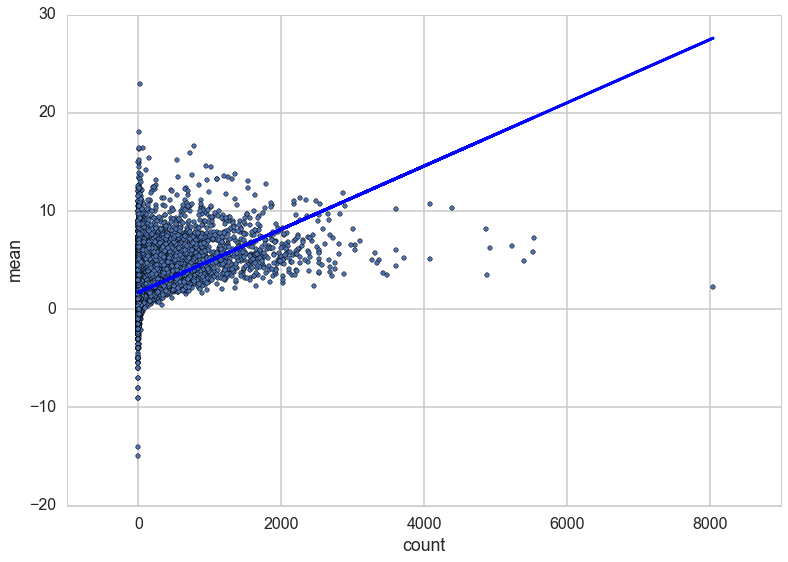

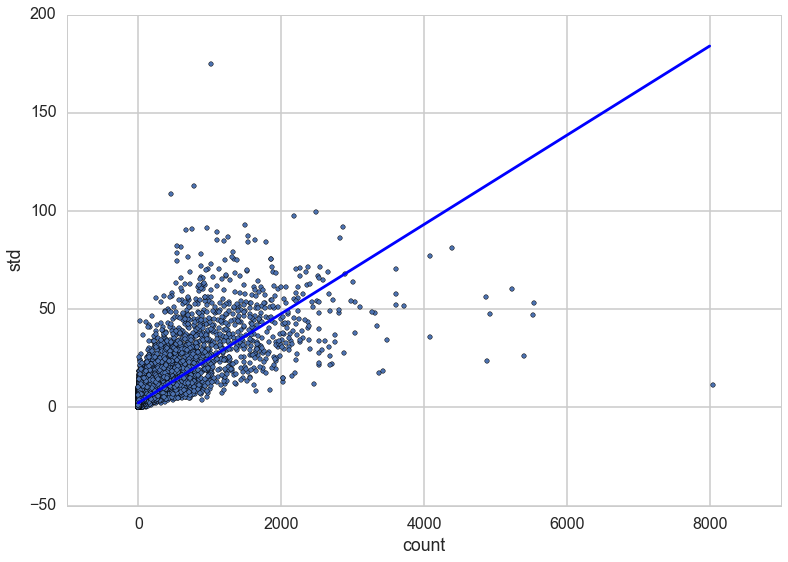

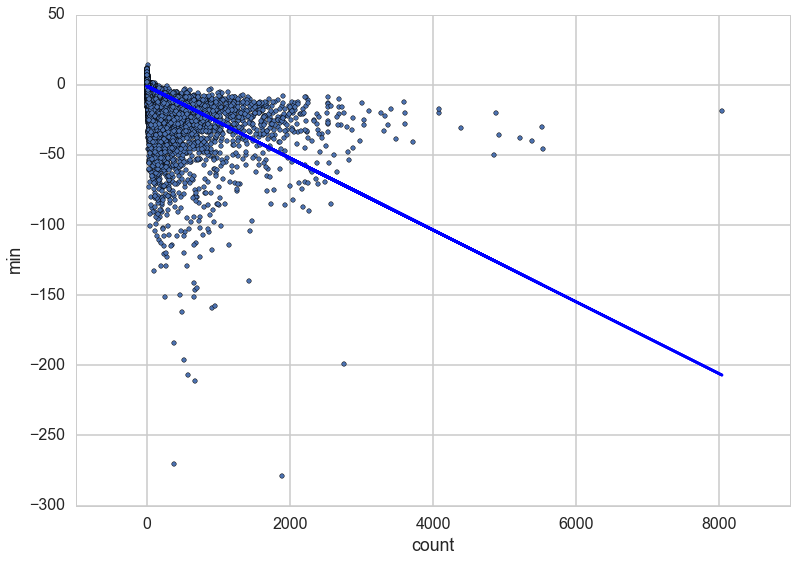

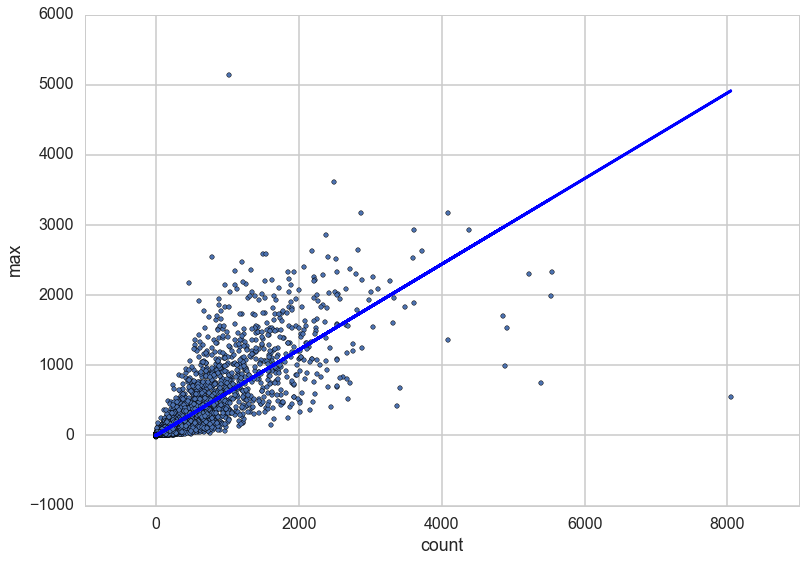

In [123]:
link_data.plot(x = 'count',y = 'mean',kind = 'scatter',layout = (4,1))
plt.plot(link_data["count"], fittedmean.fittedvalues, 'b')

link_data.plot(x = 'count',y = 'std',kind = 'scatter',layout = (4,1))
plt.plot([0,8000],[fittedstd.params[0],8000*fittedstd.params[1]+fittedstd.params[0]],'b')
#plt.plot(link_data["count"], fittedstd.fittedvalues, 'b')

link_data.plot(x = 'count',y = 'min',kind = 'scatter',layout = (4,1))
plt.plot(link_data["count"], fittedmin.fittedvalues, 'b')

link_data.plot(x = 'count',y = 'max',kind = 'scatter',layout = (4,1))
plt.plot(link_data["count"], fittedmax.fittedvalues, 'b')

# regression code taken from http://mpastell.com/2013/04/19/python_regression/

In order:

As the number of comments on an article increases, the mean of the comments converges to the population mean.  This makes sense.

As the count increases, the standard deviation seems to increase.

As the count increases, the min tends to decrease.

And as the count increases, the max tends to increase.

All expected results, although there appears to be a relatively firm cap on the max where it is no more than twice the maximum count.

Let's take a look at score related to word and sentence counts

CPU times: user 35.2 s, sys: 2.55 s, total: 37.8 s
Wall time: 37 s


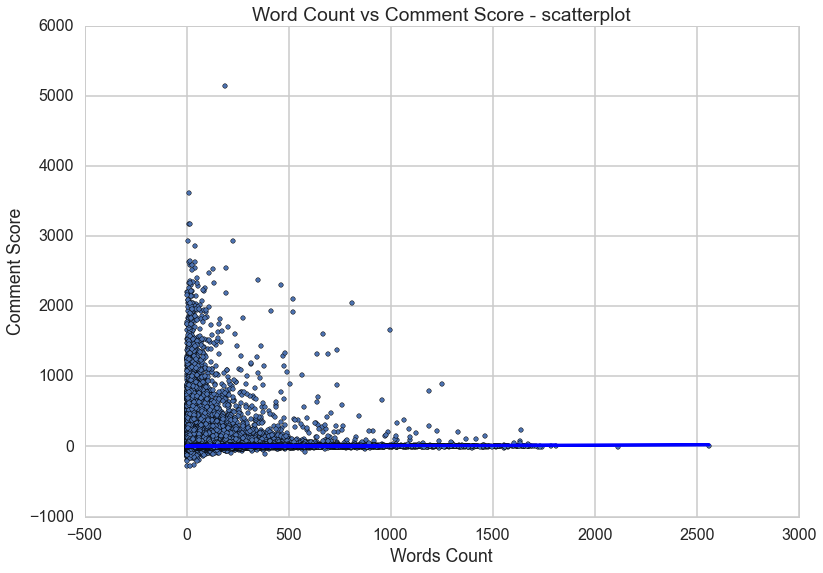

In [124]:
%%time

dfsmall = df.loc[df.index,['score','words']]
dfsmall.plot(x = 'words',y = 'score',kind = 'scatter')
plt.xlabel('Words Count')
plt.ylabel('Comment Score')
plt.title('Word Count vs Comment Score - scatterplot')

model = sm.ols(formula='score ~ words', data=dfsmall)
fittedwordscore = model.fit()
plt.plot(dfsmall["words"], fittedwordscore.fittedvalues, 'b')

CPU times: user 35.5 s, sys: 1.07 s, total: 36.6 s
Wall time: 36.2 s


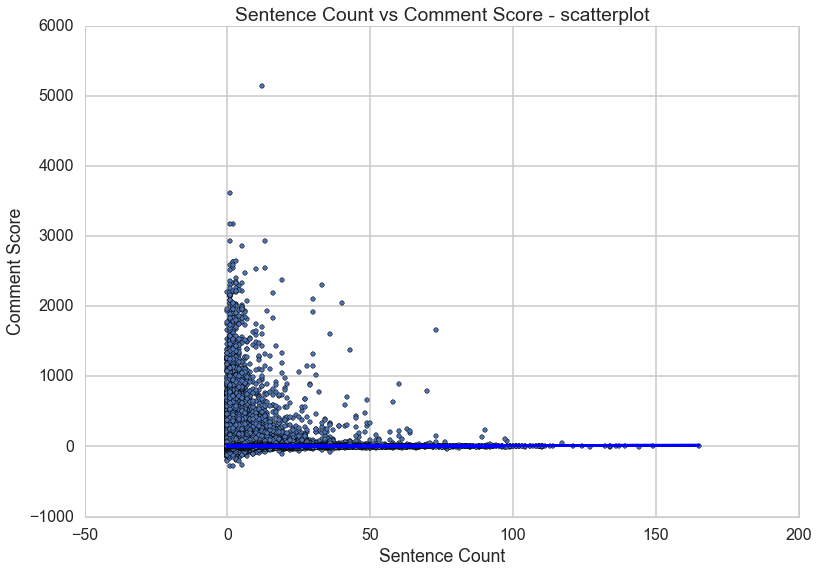

In [126]:
%%time

dfsmall = df.loc[df.index,['score','sentences']]
dfsmall.plot(x = 'sentences',y = 'score',kind = 'scatter')
plt.xlabel('Sentence Count')
plt.ylabel('Comment Score')
plt.title('Sentence Count vs Comment Score - scatterplot')

model = sm.ols(formula='score ~ sentences', data=dfsmall)
fittedsentencescore = model.fit()
plt.plot(dfsmall["sentences"], fittedsentencescore.fittedvalues, 'b')

It appears that word count and sentence count don't help your score, but it is it merely a case of exploring less of the same distributions since there are thousands fold fewer long comments?

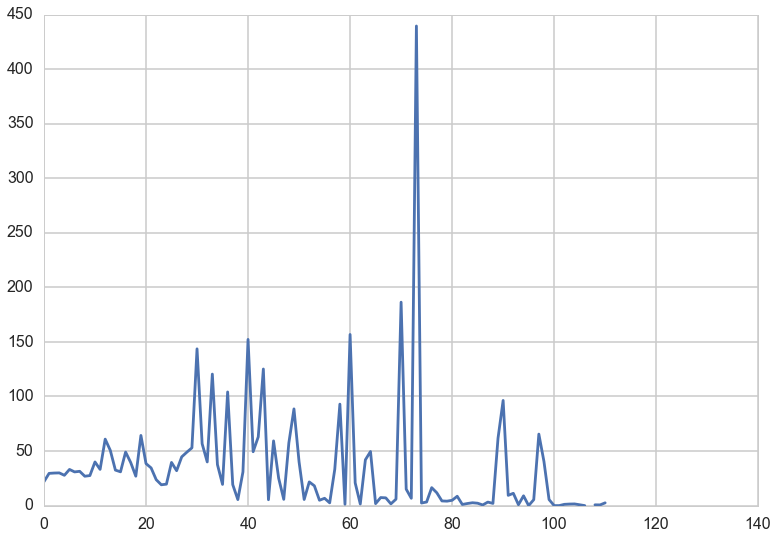

In [127]:
grouped_data = dfsmall.groupby('sentences').std()

grouped_data.index
plt.plot(grouped_data.index,grouped_data.score)
#plt.plot(np.random.rand(20),np.random.rand(20))

Curiously, it doesn't appear that the standard deviation diminishes as the word count increases (except for maybe when the sample sizes aren't big enough to get a reliable standard deviation).

# Should numbers count as words: a digression

In [169]:
words = abridged_dict.keys()
words.sort()
ordered_dict = [(i,abridged_dict[i]) for i in words]
ordered_dict

[('0', 13791),
 ("0's", 21),
 ('00', 2858),
 ("00's", 58),
 ('000', 35058),
 ("000's", 38),
 ('0000', 26),
 ('00000', 4),
 ('000000', 27),
 ('0000000', 3),
 ('00000000', 4),
 ('0000000000006561', 3),
 ('000000000001', 5),
 ('00000000001', 3),
 ('0000000001', 4),
 ('000000001', 6),
 ('00000001', 18),
 ('0000001', 24),
 ('00000013', 12),
 ('000000153', 3),
 ('0000007', 3),
 ('000001', 37),
 ('0000022', 3),
 ('000003', 4),
 ('0000031', 5),
 ('000004', 3),
 ('000007', 18),
 ('000008', 3),
 ('00001', 51),
 ('000011', 4),
 ('00002', 16),
 ('00003', 7),
 ('000035', 3),
 ('00004', 5),
 ('00005', 12),
 ('000065', 4),
 ('00007', 3),
 ('0001', 121),
 ('000103', 4),
 ('00012', 4),
 ('00014', 3),
 ('00015', 6),
 ('00017', 18),
 ('0002', 21),
 ('00025', 3),
 ('0003', 13),
 ('0004', 7),
 ('0005', 20),
 ('0006', 10),
 ('0007', 6),
 ('0008', 4),
 ('0009', 5),
 ('001', 321),
 ('00100000', 5),
 ('00100001', 3),
 ('00101011', 15),
 ('0011', 5),
 ('0014', 4),
 ('0015', 4),
 ('00154', 3),
 ('00174', 5),
 ('

In [170]:
abridged_dict['lbs']

710

Before splitting the numeric_alpha hybrids, lbs was at 425.  This actually makes me think that the split is worth it for picking up more context.

The next few plots look at 4 digit numbers and their frequencies. One point, 4 digit numbers show up a lot.  Second point, they may actually highlight interesting things like exceptionally important years or decades.

Double click plots to enlarge:

In [181]:
years = []
importance = []

for i in range(1001,2050):
    if str(i) in abridged_dict:
        years.append(i)
        importance.append(abridged_dict[str(i)])

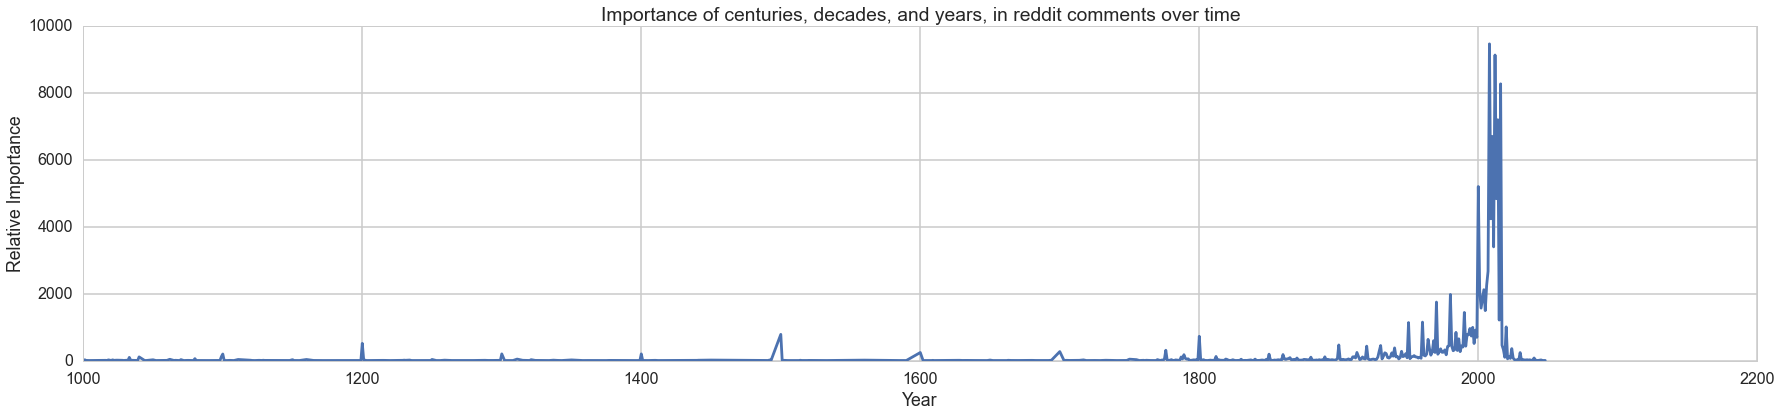

In [182]:
plt.figure(figsize = (30,6))
plt.plot(years,importance)
plt.title("Importance of centuries, decades, and years, in reddit comments over time")
plt.xlabel("Year")
plt.ylabel("Relative Importance")

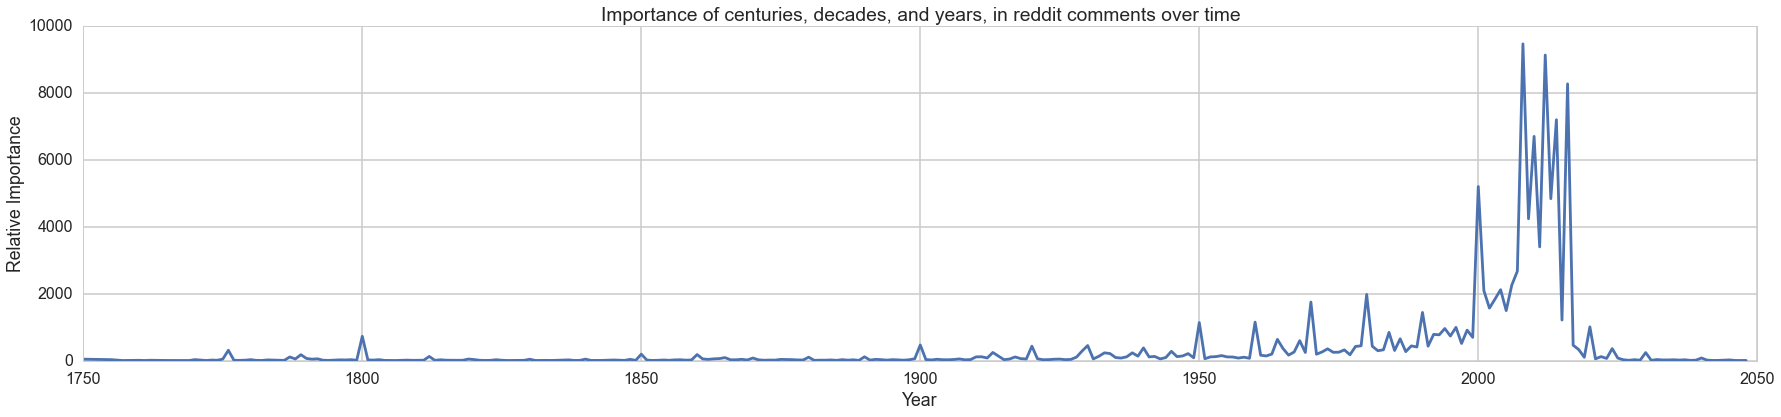

In [183]:
years = []
importance = []

for i in range(1750,2050):
    if str(i) in abridged_dict:
        years.append(i)
        importance.append(abridged_dict[str(i)])
        
plt.figure(figsize = (30,6))
plt.plot(years,importance)

plt.title("Importance of centuries, decades, and years, in reddit comments over time")
plt.xlabel("Year")
plt.ylabel("Relative Importance")

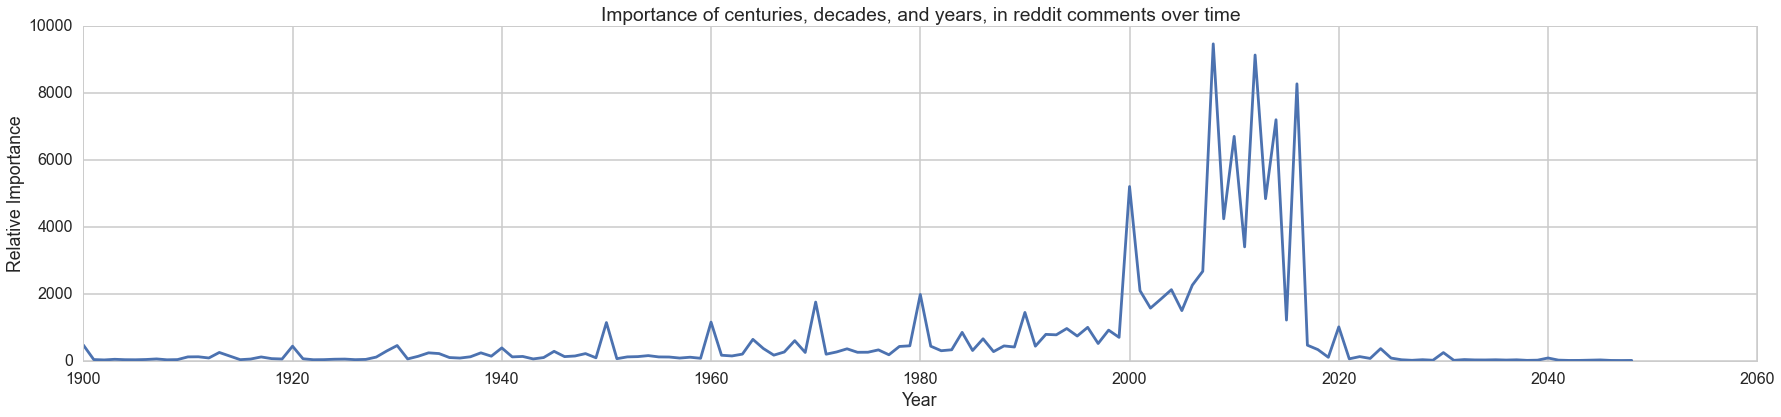

In [184]:
years = []
importance = []

for i in range(1900,2050):
    if str(i) in abridged_dict:
        years.append(i)
        importance.append(abridged_dict[str(i)])
        
plt.figure(figsize = (30,6))
plt.plot(years,importance)
#plt.vlines(x = 2015,ymin = 0, ymax = 8000, colors = 'red',label = 'Today',linewidth = 4)

#plt.vlines(x = 1914,ymin = 0, ymax = 8000, colors = 'red',label = 'Today',linewidth = 4)

plt.title("Importance of centuries, decades, and years, in reddit comments over time")
plt.xlabel("Year")
plt.ylabel("Relative Importance")

Assuming 4 digit numbers are years, the centuries seem more important than the decades, and the decades more important than the years.